## Deep Neural Network for Image Classification: Cat, Non-Cat

### 1 - Packages

In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_utils import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

## 2 - Dataset

We will use the same "Cat vs non-Cat" dataset.

Given a dataset ("data.h5") containing:
  - a training set of m_train images labelled as cat (1) or non-cat (0)
  - a test set of m_test images labelled as cat and non-cat
  - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB).

Let's get more familiar with the dataset. Load the data by running the cell below.

In [2]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

In [3]:
# Explore the dataset
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print('Number of training examples: ' + str(m_train))
print('Number of test examples: ' + str(m_test))
print('Each image is of size : (' + str(num_px) + ", " + str(num_px) + ", 3)")
print('train_x_orig shape' + str(train_x_orig.shape))
print('train_y shape' + str(train_y.shape))
print('test_x_orig shape' + str(test_x_orig.shape))
print('test_y shape' + str(test_y.shape))


Number of training examples: 209
Number of test examples: 50
Each image is of size : (64, 64, 3)
train_x_orig shape(209, 64, 64, 3)
train_y shape(1, 209)
test_x_orig shape(50, 64, 64, 3)
test_y shape(1, 50)


The following code will show an image in the dataset. Feel free to change the index and re-run the cell multiple times to see other images. 

y = 0. It's a non-cat picture.


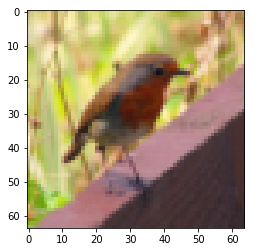

In [4]:
# Example of a picture
index = 10
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

y = 1. It's a cat picture.


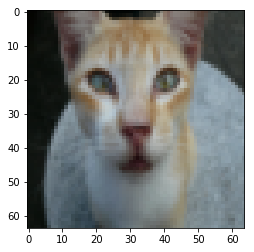

In [5]:
# Example of a picture
index = 11
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

As usual, we reshape and standardize the images before feeding them to the network. The code is given in the cell below.

<img src="images/imvectorkiank.png" style="width:450px;height:300px;">

<caption><center> <u>Figure 1</u>: Image to vector conversion. <br> </center></caption>

In [6]:
# Reshape the training and test examples
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T# The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize the data to have featuree values between 0 and 
train_x = train_x_flatten / 255
test_x = test_x_flatten / 255

print("train_x's shape: " + str(train_x.shape))
print("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


## 3 - Architecture of your model


Now that we are familiar with the dataset, it is time to build a deep neural network to distinguish cat images from non-cat images.

We will build two different models:
- A 2-layer neural network
- An L-layer deep neural network

We will then compare the performance of these models, and also try out different values for $L$. 

Let's look at the two architectures.

### 3.1 - 2-layer neural network

<img src="images/2layerNN_kiank.png" style="width:650px;height:400px;">
<caption><center> <u>Figure 2</u>: 2-layer neural network. <br> The model can be summarized as: ***INPUT -> LINEAR -> RELU -> LINEAR -> SIGMOID -> OUTPUT***. </center></caption>

<u>Detailed Architecture of figure 2</u>:
- The input is a (64,64,3) image which is flattened to a vector of size $(12288,1)$. 
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ of size $(n^{[1]}, 12288)$.
- You then add a bias term and take its relu to get the following vector: $[a_0^{[1]}, a_1^{[1]},..., a_{n^{[1]}-1}^{[1]}]^T$.
- We then repeat the same process.
- We multiply the resulting vector by $W^{[2]}$ and add our intercept (bias). 
- Finally, We take the sigmoid of the result. If it is greater than 0.5, We classify it to be a cat.

### 3.2 - L-layer deep neural network

It is hard to represent an L-layer deep neural network with the above representation. However, here is a simplified network representation:

<img src="images/LlayerNN_kiank.png" style="width:650px;height:400px;">
<caption><center> <u>Figure 3</u>: L-layer neural network. <br> The model can be summarized as: ***[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID***</center></caption>

<u>Detailed Architecture of figure 3</u>:
- The input is a (64,64,3) image which is flattened to a vector of size (12288,1).
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ and then we add the intercept $b^{[1]}$. The result is called the linear unit.
- Next, we take the relu of the linear unit. This process could be repeated several times for each $(W^{[l]}, b^{[l]})$ depending on the model architecture.
- Finally, we take the sigmoid of the final linear unit. If it is greater than 0.5, we classify it to be a cat.

### 3.3 - General methodology

As usual we will follow the Deep Learning methodology to build the model:
    1. Initialize parameters / Define hyperparameters
    2. Loop for num_iterations:
        a. Forward propagation
        b. Compute cost function
        c. Backward propagation
        d. Update parameters (using parameters, and grads from backprop) 
    4. Use trained parameters to predict labels

Let's now implement those two models!

## 4 - Two-layer neural network

**Question**:  Use the helper functions you have implemented in the previous assignment to build a 2-layer neural network with the following structure: *LINEAR -> RELU -> LINEAR -> SIGMOID*. The functions you may need and their inputs are:
```python
def initialize_parameters(n_x, n_h, n_y):
    ...
    return parameters 
def linear_activation_forward(A_prev, W, b, activation):
    ...
    return A, cache
def compute_cost(AL, Y):
    ...
    return cost
def linear_activation_backward(dA, cache, activation):
    ...
    return dA_prev, dW, db
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [7]:
# CONSTANTS DEFINING THE MODEL
n_x = 64*64*3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [8]:
# Two_Layer_Model
def two_layer_model(X, Y, layers_dims, learning_rate=0.0075,num_iters=3000,print_cost=False):
    np.random.seed(1)
    grads = {}
    costs = []
    (n_x, n_h, n_y) = layers_dims
    
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Gradient Descent
    for i in range(0, num_iters):
        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID.
        A1, cache1 = linear_activation_forward(X, W1, b1, activation='relu')
        A2, cache2 = linear_activation_forward(A1, W2, b2, activation='sigmoid')
        
        # Compute cost
        cost = compute_cost(A2, Y)
        
        # Initializing backward Prpagation
        dA2 = -(np.divide(Y, A2) - np.divide(1-Y, 1-A2))
        
        # Backward Prpagation
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, activation='sigmoid')
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, activation='relu')
        
        grads["dW1"] = dW1
        grads["db1"] = db1
        grads["dW2"] = dW2
        grads["db2"] = db2
        
        # Update the parameters
        parameters = update_parameters(parameters, grads, learning_rate=learning_rate)
        
        W1 = parameters['W1']
        b1 = parameters['b1']
        W2 = parameters['W2']
        b2 = parameters['b2']
        
        if print_cost and i % 100 == 0:
            print("Cost after iteraion {}: {}".format(i, np.squeeze(cost)))
            costs.append(cost)
            
    #Plot the Cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('Cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters
        

Cost after iteraion 0: 0.6930497356599888
Cost after iteraion 100: 0.6464320953428849
Cost after iteraion 200: 0.6325140647912677
Cost after iteraion 300: 0.6015024920354665
Cost after iteraion 400: 0.5601966311605748
Cost after iteraion 500: 0.5158304772764729
Cost after iteraion 600: 0.4754901313943325
Cost after iteraion 700: 0.43391631512257495
Cost after iteraion 800: 0.4007977536203889
Cost after iteraion 900: 0.3580705011323798
Cost after iteraion 1000: 0.3394281538366413
Cost after iteraion 1100: 0.3052753636196264
Cost after iteraion 1200: 0.2749137728213016
Cost after iteraion 1300: 0.24681768210614832
Cost after iteraion 1400: 0.1985073503746612
Cost after iteraion 1500: 0.17448318112556635
Cost after iteraion 1600: 0.17080762978095823
Cost after iteraion 1700: 0.11306524562164749
Cost after iteraion 1800: 0.09629426845937161
Cost after iteraion 1900: 0.08342617959726865
Cost after iteraion 2000: 0.07439078704319083
Cost after iteraion 2100: 0.0663074813226793
Cost after ite

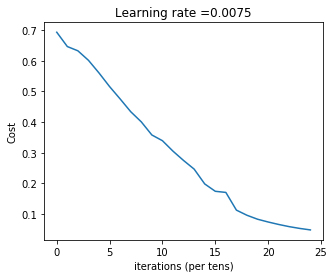

In [9]:
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iters = 2500, print_cost=True)

Now, We can use the trained parameters to classify images from the dataset. To see our predictions on the training and test sets, run the cell below.

In [10]:
# Train Accuracy
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 1.0


In [11]:
# Test Accuracy 
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.72


## 5 - L-layer Neural Network

**Question**: Use the helper functions we have implemented previously to build an $L$-layer neural network with the following structure: *[LINEAR -> RELU]$\times$(L-1) -> LINEAR -> SIGMOID*. The functions you may need and their inputs are:
```python
def initialize_parameters_deep(layer_dims):
    ...
    return parameters 
def L_model_forward(X, parameters):
    ...
    return AL, caches
def compute_cost(AL, Y):
    ...
    return cost
def L_model_backward(AL, Y, caches):
    ...
    return grads
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [12]:
# L_Layer_Model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
 
    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization.
    parameters = initialize_parameters_deep(layers_dims)
   
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        # Compute cost.
        cost = compute_cost(AL, Y)
    
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
 
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate=learning_rate)
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

You will now train the model as a 6-layer neural network. 

In [19]:
# CONSTANTS DEFINING THE MODEL
### CONSTANTS ###
layers_dims = [12288, 25, 11, 9, 5,  1] #  6-layer model

In [20]:
len(layers_dims)

6

Cost after iteration 0: 0.727617
Cost after iteration 100: 0.663542
Cost after iteration 200: 0.619664
Cost after iteration 300: 0.567292
Cost after iteration 400: 0.571199
Cost after iteration 500: 0.471358
Cost after iteration 600: 0.472327
Cost after iteration 700: 0.344208
Cost after iteration 800: 0.313326
Cost after iteration 900: 0.267945
Cost after iteration 1000: 0.242129
Cost after iteration 1100: 0.202540
Cost after iteration 1200: 0.185985
Cost after iteration 1300: 0.170185
Cost after iteration 1400: 0.158158
Cost after iteration 1500: 0.148160
Cost after iteration 1600: 0.140139
Cost after iteration 1700: 0.131885
Cost after iteration 1800: 0.125383
Cost after iteration 1900: 0.119663
Cost after iteration 2000: 0.114588
Cost after iteration 2100: 0.110465
Cost after iteration 2200: 0.106010
Cost after iteration 2300: 0.102488
Cost after iteration 2400: 0.099249


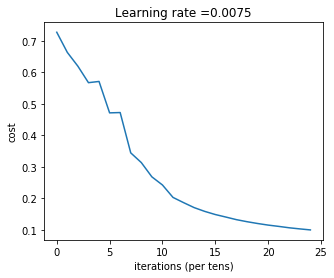

In [21]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations= 2500, print_cost = True)

### Check Training, Test Accuracy

In [22]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.99043062201


In [23]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.82


##  6) Results Analysis

First, let's take a look at some images the L-layer model labeled incorrectly. This will show a few mislabeled images. 

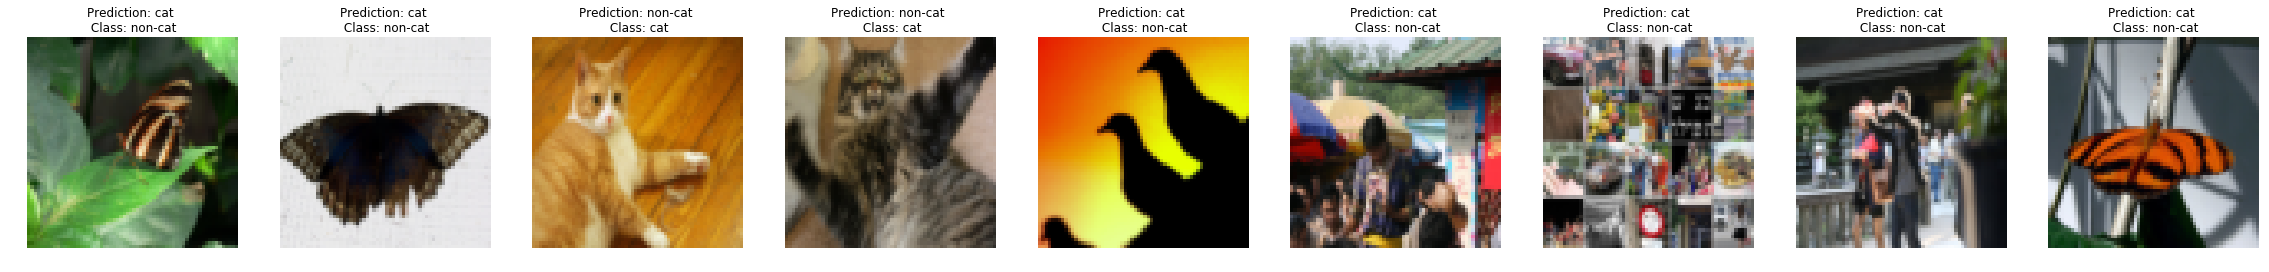

In [24]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

**A few type of images the model tends to do poorly on include:** 
- Cat body in an unusual position
- Cat appears against a background of a similar color
- Unusual cat color and species
- Camera Angle
- Brightness of the picture
- Scale variation (cat is very large or small in image) 

## 7) Test with our own image 


Accuracy: 1.0
y = 1.0, your L-layer model predicts a "cat" picture.


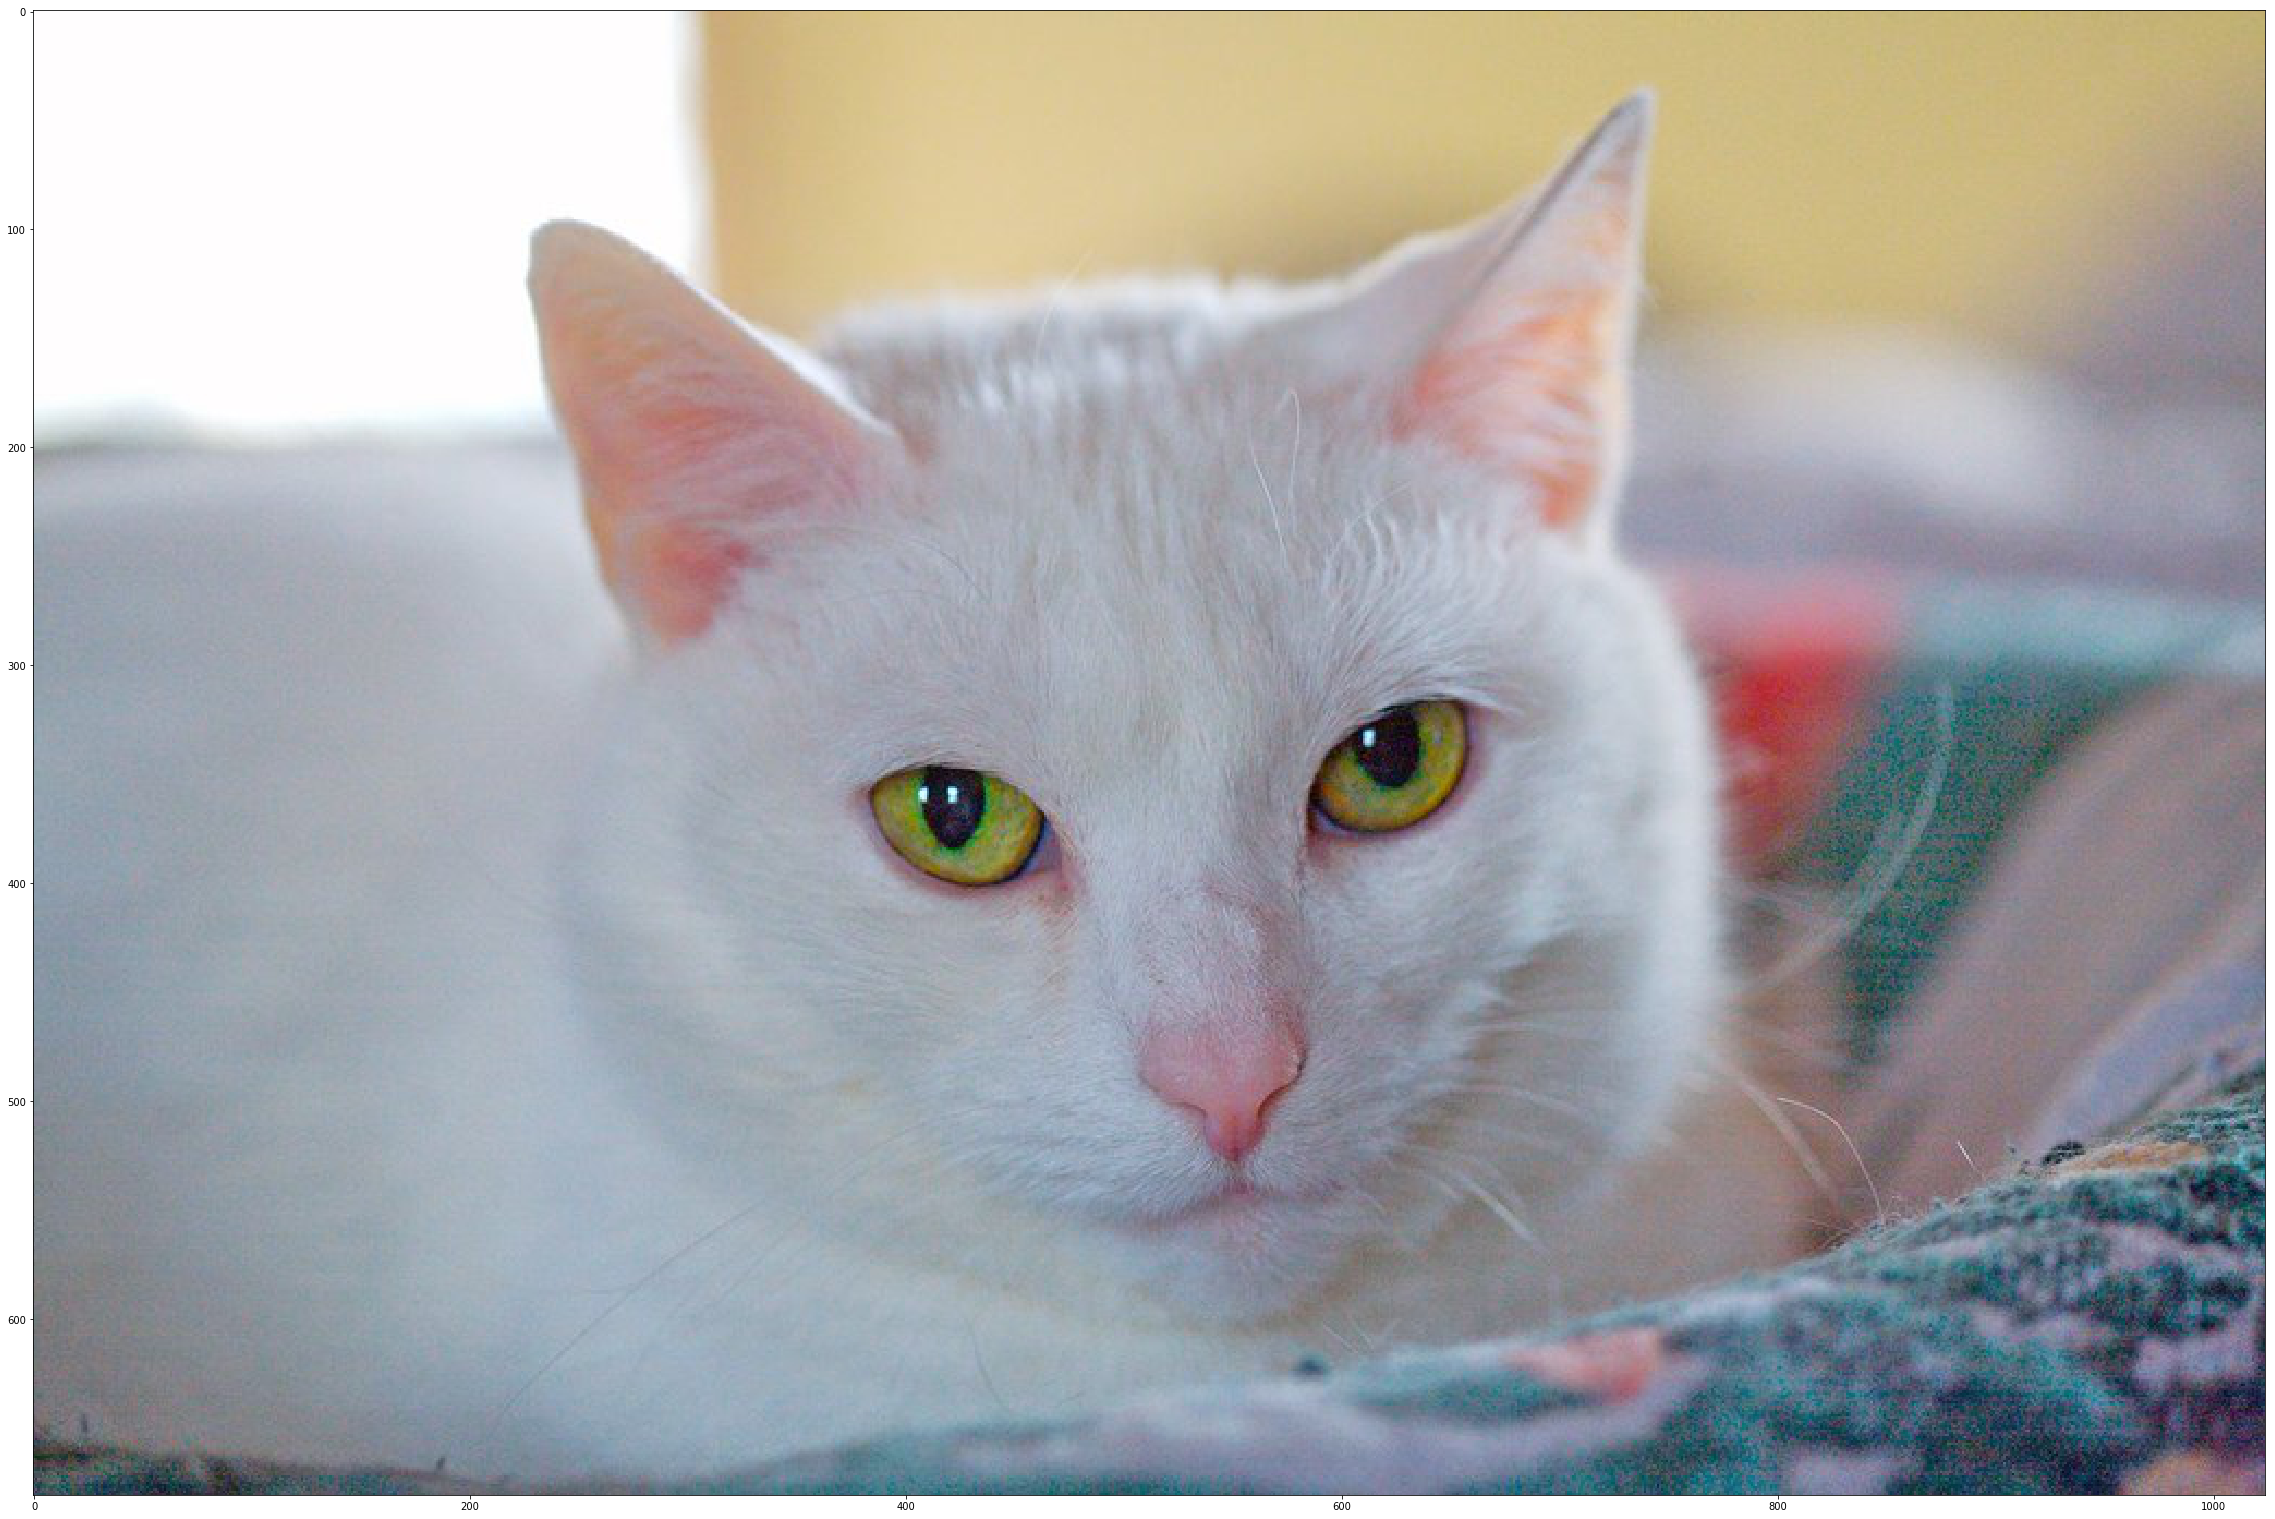

In [27]:
my_image = "my_image.jpg"
my_label_y = [1]

fname = "images/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((num_px*num_px*3, 1))

my_predicted_image = predict(my_image, my_label_y, parameters)


plt.imshow(image)
print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

## End of Deep Neural Network for Image Classification Project